# Classification. Linear models and KNN

In [80]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [82]:
from sklearn.exceptions import NotFittedError

In [83]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

         
    def get_sigmoid(self,X, weights):
        """Compute the sigmoid value."""
        power = np.dot(X, weights)
        sigmoid = 1.0/(1 + np.exp(-power))
        return sigmoid
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        X_T = x.transpose()
        loss = (np.sum(np.log(1+np.exp(-np.dot(weights,X_T))*y)))/len(y)+\
        (1/(2*self.C))*np.linalg.norm(weights)
        
        return loss
        
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        loss_value=[]
        for i in range(self.max_iter):
            X_ext_T = X_ext.transpose()
            delta = self.weights_/self.C \
            - (np.dot(X_ext_T, (y * (1 - 1 / (1 + np.exp(-np.dot(self.weights_,X_ext_T)*y))))))/len(y)
            self.weights_ -= self.eta * delta
            if np.linalg.norm(delta)<self.tol:
                break
                

     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        #if self.predict_proba(X) 
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)
        

In [84]:
from sklearn import datasets
from sklearn import metrics

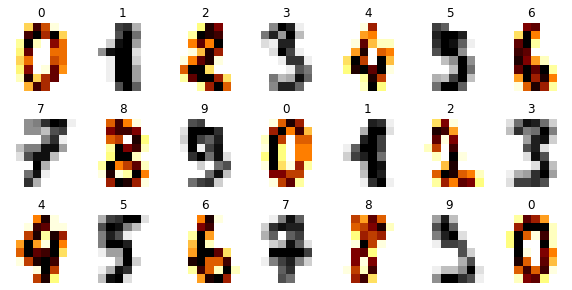

In [85]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1


In [86]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [87]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [88]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [89]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [90]:
lr_clf.fit(X_train, y_train)

In [91]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [92]:
model = CustomLogisticRegression()

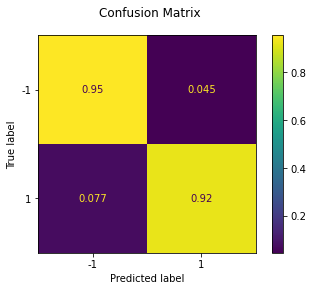

In [93]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [94]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [95]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [96]:
#

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

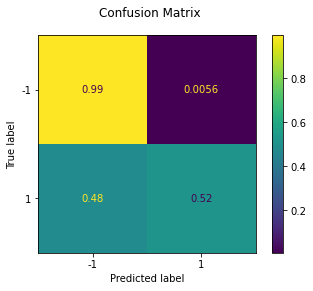

(0.7731384829505915, 0.7527777777777778)

In [97]:
eta = 0.01
model_1 = CustomLogisticRegression(eta=0.01)
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)
train_acc, test_acc

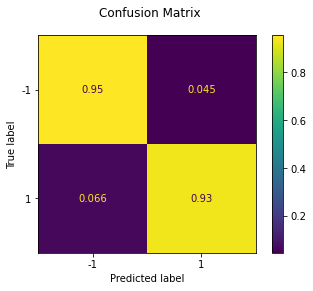

(0.9144050104384134, 0.9444444444444444)

In [98]:
eta = 0.002
model_2 = CustomLogisticRegression(eta=0.002)
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)
train_acc, test_acc

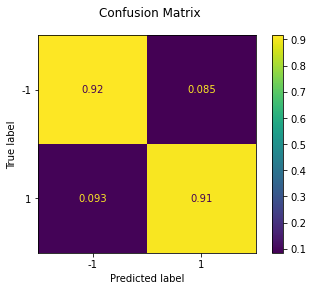

(0.8844815588030619, 0.9111111111111111)

In [99]:
eta = 0.0001
model_3 = CustomLogisticRegression(eta=0.0001)
train_acc, test_acc = fit_evaluate(model_3, X_train, y_train, X_test, y_test)
train_acc, test_acc

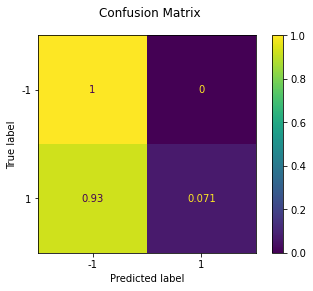

(0.5455810716771051, 0.5277777777777778)

In [100]:
eta = 0.1
model_4 = CustomLogisticRegression(eta=0.1)
train_acc, test_acc = fit_evaluate(model_4, X_train, y_train, X_test, y_test)
train_acc, test_acc

With higher learning rate we can see worth prediction, with smallest - better, but when take the smalliest learning rate we need more time and power of machine

**(0.5 points)** Try different regularization parameter values and compare the model quality.

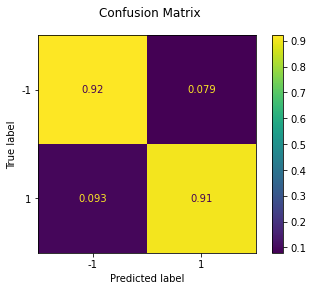

(0.8879610299234516, 0.9138888888888889)

In [101]:
C = 0.1
model_5 = CustomLogisticRegression(C=0.1)
train_acc, test_acc = fit_evaluate(model_5, X_train, y_train, X_test, y_test)
train_acc, test_acc

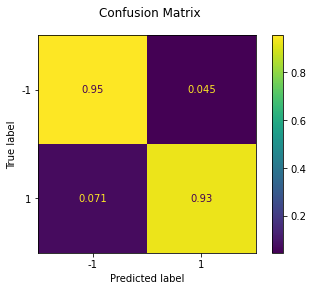

(0.9151009046624913, 0.9416666666666667)

In [102]:
C = 10
model_6 = CustomLogisticRegression(C=10)
train_acc, test_acc = fit_evaluate(model_6, X_train, y_train, X_test, y_test)
train_acc, test_acc

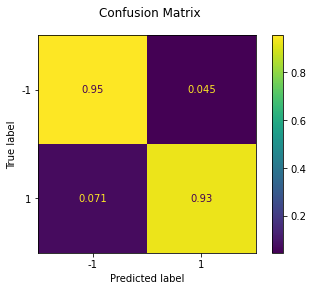

(0.9144050104384134, 0.9416666666666667)

In [103]:
C = 50
model_7 = CustomLogisticRegression(C=50)
train_acc, test_acc = fit_evaluate(model_7, X_train, y_train, X_test, y_test)
train_acc, test_acc

regularization can be used to train models that generalize better on unseen data, by preventing the algorithm from overfitting the training dataset.

**(0.5 points)** Compare zero initialization and random initialization. 

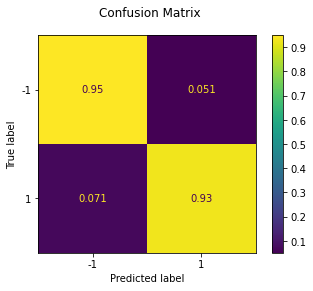

(0.9116214335421016, 0.9388888888888889)

In [104]:
model_7 = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model_7, X_train, y_train, X_test, y_test)
train_acc, test_acc

With zero initialization we have a litlle bite better train accuracy 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [177]:
from sklearn.metrics.pairwise import euclidean_distances
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return euclidean_distances(X,Y)

    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        weights_sum = []
        for n in self.classes_:
            weights_class = 0
            for k in range(len(y)):
                if y[k] == n:
                    weights_class += weights[k]
            weights_sum.append(weights_class)
        return weights_sum

        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            close = np.argsort(P,axis=1)[:,:self.n_neighbors]
            dist = P[np.arange(len(P))[:,None], close]
            c_class = self.y[close]
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / np.maximum(dist, self.eps)
            y=[]
            for i in range(len(P)):
                y.append(self.get_class_weights(c_class[i], weights_of_points[i]))
            return np.array(np.array(y) / np.expand_dims(np.array(y).sum(axis=1), 1))
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return self.predict_proba(X).argmax(axis=1)

In [178]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [179]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [180]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

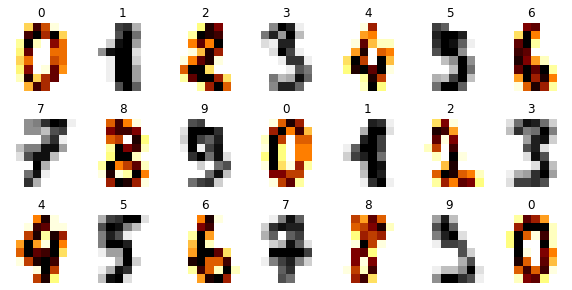

In [181]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [182]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [183]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))


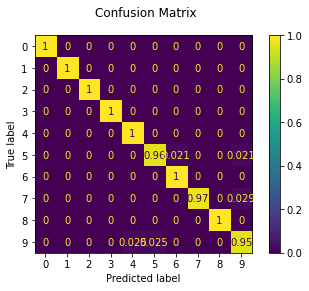

In [184]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [185]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

numbers 5/9,4/9,7/9,5/6
parts of this numbers look like similar for programm

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

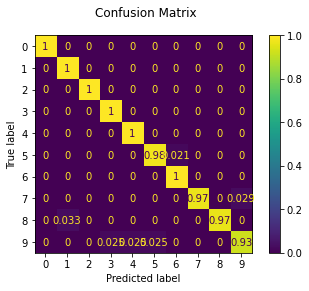

In [114]:
model = CustomKNeighborsClassifier(n_neighbors=3, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

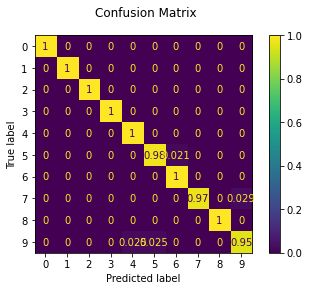

In [115]:
model = CustomKNeighborsClassifier(n_neighbors=7, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

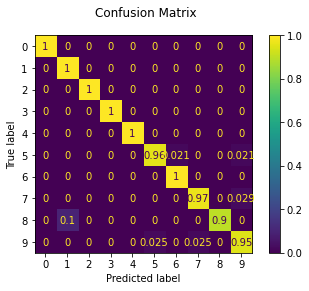

In [116]:
model = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

for smallest number of neihbours we can see worst accurace , for bigger - better, but if we set high number accuracy also get worst

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

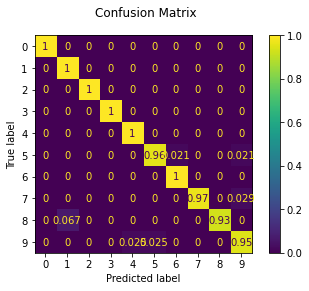

In [119]:
model = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

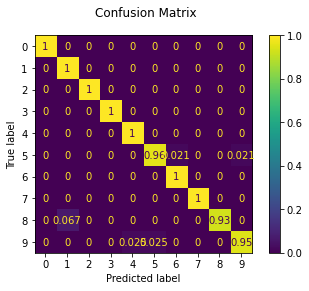

In [120]:
model = CustomKNeighborsClassifier(n_neighbors=10, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

As we can see for k=10 our matrix are the same

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

there next distance measurement for kNN:
- Euclidean distance
- cosine similarity measure 
- Minkowsky
- Chi square

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
#PATH = "./data/"

In [ ]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [121]:
data = pd.read_csv('train.csv').set_index('PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


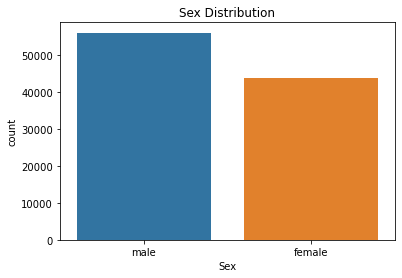

<Figure size 432x288 with 0 Axes>

In [122]:
sns.countplot(data['Sex'])
plt.title('Sex Distribution')
plt.show()
plt.clf()

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


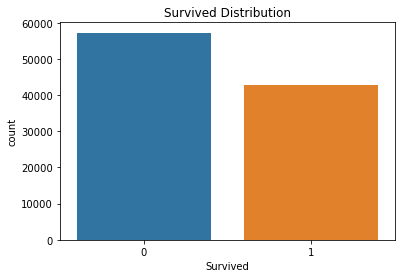

<Figure size 432x288 with 0 Axes>

In [123]:
sns.countplot(data['Survived'])
plt.title('Survived Distribution')
plt.show()
plt.clf()

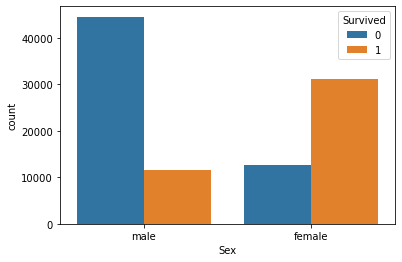

In [124]:
sns.countplot(x="Sex", hue="Survived",data=data)
plt.show()

There more survived womens on Titanic

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

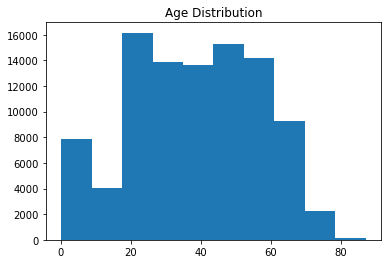

<Figure size 432x288 with 0 Axes>

In [125]:
plt.hist(data['Age'])
plt.title('Age Distribution')
plt.show()
plt.clf()


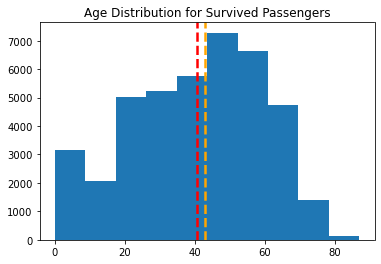

<Figure size 432x288 with 0 Axes>

In [126]:
plt.hist(data[(data.Survived==1)].Age)
plt.title('Age Distribution for Survived Passengers')
plt.axvline(x=data[(data.Survived==1)].Age.mean(),color='red',ls='--', lw=2.5)
plt.axvline(x=data[(data.Survived==1)].Age.median(),color='orange',ls='--', lw=2.5)
plt.show()
plt.clf()

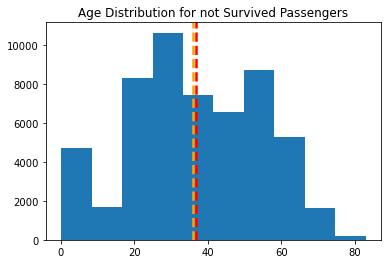

<Figure size 432x288 with 0 Axes>

In [127]:
plt.hist(data[(data.Survived==0)].Age)
plt.title('Age Distribution for not Survived Passengers')
plt.axvline(x=data[(data.Survived==0)].Age.mean(),color='red',ls='--', lw=2.5)
plt.axvline(x=data[(data.Survived==0)].Age.median(),color='orange',ls='--', lw=2.5)
plt.show()
plt.clf()

Yes, age distribution are different for survived and not survived passengers.
There can be a lot of factors why age influnces on survival. Maybe elder people had more money to buy ticket on higher class or maybe elder people more egoistic and try to save themselves :)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


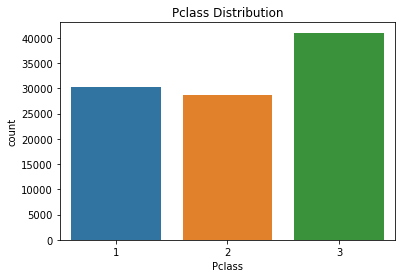

<Figure size 432x288 with 0 Axes>

In [128]:
sns.countplot(data['Pclass'])
plt.title('Pclass Distribution')
plt.show()
plt.clf()


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


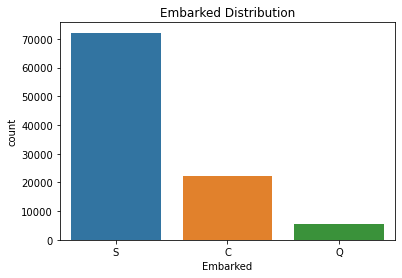

<Figure size 432x288 with 0 Axes>

In [129]:
sns.countplot(data['Embarked'])
plt.title('Embarked Distribution')
plt.show()
plt.clf()


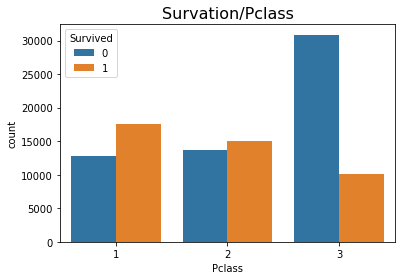

In [130]:
plt.clf()
sns.countplot(x="Pclass", hue="Survived",data = data)
plt.title('Survation/Pclass',size=16)
plt.show()


Highest likelihood of survation had passengers from 1st class 

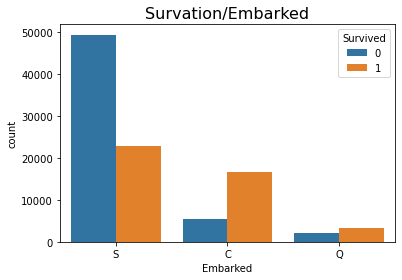

In [131]:
plt.clf()
sns.countplot(x="Embarked", hue="Survived",data = data)
plt.title('Survation/Embarked',size=16)
plt.show()

Also on this graph we can see relationship between embarkation port and survation

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [132]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing}).set_index('column_name')
missing_value_df 

,percent_missing
column_name,
Survived,0.000
Pclass,0.000
Name,0.000
Sex,0.000
Age,3.292
SibSp,0.000
Parch,0.000
Ticket,4.623
Fare,0.134


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

1. We can drop the column with the high percent of missing values, but it is not good idea.
2. We can fill Na values with mode, mean or median value
3. We can transform column with 1 for value and 0 for Na

I think 3rd method will be good for Cabin column

Age and Fare columns we can fill vith mean value

Embarked with mode value

From ticket column we can extract letters and transform column with 1 for value with letters and 0 for NaNs and thickets without letters


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [133]:
from scipy import stats
import re
#Prepare data
#Embarked
embarked_mode = stats.mode(data.Embarked)[0][0]
data.Embarked = data.Embarked.fillna(embarked_mode)
data.Embarked  = data.Embarked.replace({'S': 1, 'C': 2,'Q':3})
#Fare
fare_mean_1class = data[(data.Pclass == 1)].Fare.mean()
fare_mean_2class = data[(data.Pclass == 2)].Fare.mean()
fare_mean_3class = data[(data.Pclass == 3)].Fare.mean()
data.loc[data.Pclass == 1,'Fare'] = data[data.Pclass == 1].Fare.fillna(fare_mean_1class)
data.loc[data.Pclass == 2,'Fare'] = data[data.Pclass == 2].Fare.fillna(fare_mean_2class)
data.loc[data.Pclass == 3,'Fare'] = data[data.Pclass == 3].Fare.fillna(fare_mean_3class)
#Age
age_mean_1class = data[(data.Pclass == 1)].Age.mean()
age_mean_2class = data[(data.Pclass == 2)].Age.mean()
age_mean_3class = data[(data.Pclass == 3)].Age.mean()
data.loc[data.Pclass == 1,'Age'] = data[data.Pclass == 1].Age.fillna(age_mean_1class)
data.loc[data.Pclass == 2,'Age'] = data[data.Pclass == 2].Age.fillna(age_mean_2class)
data.loc[data.Pclass == 3,'Age'] = data[data.Pclass == 3].Age.fillna(age_mean_3class)
#Cabin
data.Cabin = data.Cabin.replace(to_replace=r'([A-Z])\w+', value=1, regex=True)
data.Cabin=data.Cabin.fillna(0)
#Sex
data.Sex  = data.Sex.replace({'male': 0, 'female': 1})
#drop Ticket column
data = data.drop(columns=['Ticket'])
data.head()
#data.Ticket = data.Ticket.replace(to_replace=r'([A-Z ])\w+', value=int(1), regex=True)
#data.Ticket = np.where((data.Ticket != 1), int(0),data.Ticket)
#pd.to_numeric(data.Ticket, downcast="integer")
#drop Name column
data = data.drop(columns=['Name'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
0,1,1,0,44.774464,2,0,27.14,1.0,1
1,0,3,0,33.407362,0,0,13.35,0.0,1
2,0,3,0,0.330000,1,2,71.29,0.0,1
3,0,3,0,19.000000,0,0,13.04,0.0,1
4,1,3,0,25.000000,0,0,7.76,0.0,1


In [134]:
data.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin       float64
Embarked      int64
dtype: object

In [135]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing}).set_index('column_name')
missing_value_df 

,percent_missing
column_name,
Survived,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
Cabin,0.0
Embarked,0.0


Text(0.5, 1.0, 'Correlation Heatmap')

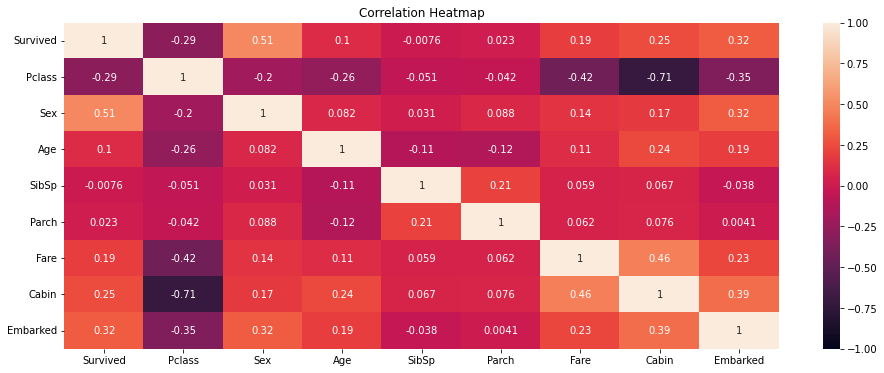

In [136]:
#take a look for correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(),vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap')

In [137]:
#for classification tasks highly recommend to delete collinear features with coefficient >0.7
#I'd like to delete Cabin column
data = data.drop(columns=['Cabin'])
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
0,1,1,0,44.774464,2,0,27.14,1
1,0,3,0,33.407362,0,0,13.35,1
2,0,3,0,0.330000,1,2,71.29,1
3,0,3,0,19.000000,0,0,13.04,1
4,1,3,0,25.000000,0,0,7.76,1


Text(0.5, 1.0, 'Correlation Heatmap')

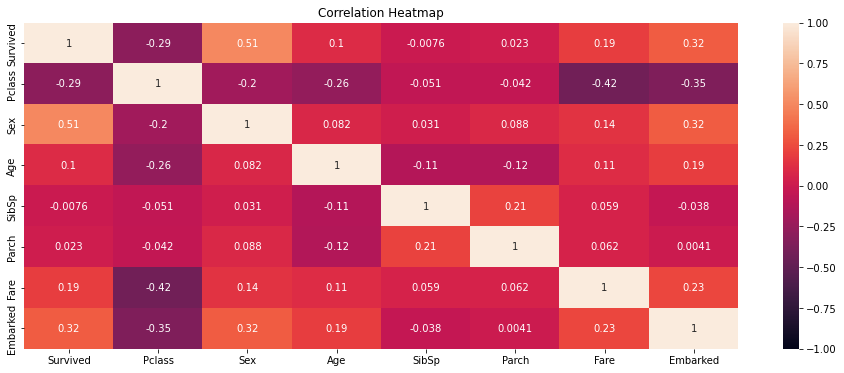

In [138]:
#check corrmatrix again
plt.figure(figsize=(16, 6))
sns.heatmap(data.corr(),vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap')

In [139]:
#also we need to scale our features(Age and Fare)
from sklearn.preprocessing import MinMaxScaler
y = data['Survived']
X = data.drop('Survived',axis= 1)
mms = MinMaxScaler()
X[['Age','Fare']] = mms.fit_transform(X[['Age','Fare']])

X.describe()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2.106910,0.43886,0.440307,0.397690,0.454560,0.058132,1.330350
std,0.837727,0.49625,0.207432,0.862566,0.950076,0.093486,0.574197
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.00000,0.286700,0.000000,0.000000,0.012581,1.000000
50%,2.000000,0.00000,0.443526,0.000000,0.000000,0.031977,1.000000
75%,3.000000,1.00000,0.608836,1.000000,1.000000,0.044114,2.000000
max,3.000000,1.00000,1.000000,8.000000,9.000000,1.000000,3.000000


In [140]:
y = data['Survived']
X = data.drop('Survived',axis= 1)


In [141]:
from sklearn.model_selection import cross_val_score
k_scores =[]
k_range = range(1, 50)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5,scoring='accuracy')
    k_scores.append(scores.mean())


In [142]:
k_range[np.argmax(k_scores)]

25

In [143]:
knn = KNeighborsClassifier(n_neighbors=25)
scores = cross_val_score(knn, X, y, cv=5,scoring='accuracy')
print(scores.mean())

0.73229


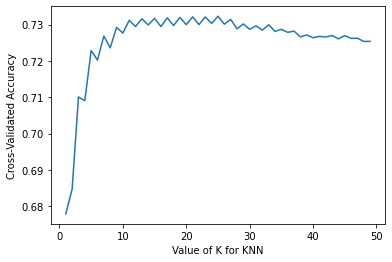

In [144]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [145]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2', random_state = 0, class_weight='balanced', n_jobs=4)
scores = cross_val_score(logreg, X, y, cv=5)
print('Cross-Validation Accuracy Score', scores.mean())

Cross-Validation Accuracy Score 0.76209


I decide to use Logostic Regression, it has better accuracy. Also before preparing features accuracy was better :)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [149]:
logreg.fit(X,y)

LogisticRegression(class_weight='balanced', n_jobs=4, random_state=0)

In [146]:
test = pd.read_csv('train.csv').set_index('PassengerId')
test.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [147]:
#Prepare data
#Embarked
embarked_mode = stats.mode(test.Embarked)[0][0]
test.Embarked = data.Embarked.fillna(embarked_mode)
test.Embarked  = data.Embarked.replace({'S': 1, 'C': 2,'Q':3})
#Fare
fare_mean_1class = test[(test.Pclass == 1)].Fare.mean()
fare_mean_2class = test[(test.Pclass == 2)].Fare.mean()
fare_mean_3class = test[(test.Pclass == 3)].Fare.mean()
test.loc[test.Pclass == 1,'Fare'] = test[test.Pclass == 1].Fare.fillna(fare_mean_1class)
test.loc[test.Pclass == 2,'Fare'] = test[test.Pclass == 2].Fare.fillna(fare_mean_2class)
test.loc[test.Pclass == 3,'Fare'] = test[test.Pclass == 3].Fare.fillna(fare_mean_3class)
#Age
age_mean_1class = test[(test.Pclass == 1)].Age.mean()
age_mean_2class = test[(test.Pclass == 2)].Age.mean()
age_mean_3class = test[(test.Pclass == 3)].Age.mean()
test.loc[test.Pclass == 1,'Age'] = test[test.Pclass == 1].Age.fillna(age_mean_1class)
test.loc[test.Pclass == 2,'Age'] = test[test.Pclass == 2].Age.fillna(age_mean_2class)
test.loc[test.Pclass == 3,'Age'] = test[test.Pclass == 3].Age.fillna(age_mean_3class)
#Cabin
test.Cabin = test.Cabin.replace(to_replace=r'([A-Z])\w+', value=1, regex=True)
test.Cabin=test.Cabin.fillna(0)
#Sex
test.Sex  = test.Sex.replace({'male': 0, 'female': 1})
#drop Ticket column
test = test.drop(columns=['Ticket'])
#drop Name column
test= test.drop(columns=['Name'])
#drop Cabin column
test = test.drop(columns=['Cabin'])
test.head()
X_test = test
mms = MinMaxScaler()
X_test[['Age','Fare']] = mms.fit_transform(X_test[['Age','Fare']])

In [161]:
y_test=test['Survived']
X_test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
0,1,1,0,0.514202,2,0,0.035565,1
1,0,3,0,0.383426,0,0,0.017030,1
2,0,3,0,0.002876,1,2,0.094908,1
3,0,3,0,0.217671,0,0,0.016613,1
4,1,3,0,0.286700,0,0,0.009516,1


In [156]:
y_pred = logreg.predict(X_test.drop('Survived',axis= 1))
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [164]:
score = logreg.score(X_test.drop('Survived',axis= 1), y_test)
print(score)

0.76367


In [159]:
#pred=pd.read_csv('train.csv')
#pred['Survived']=y_pred 
#to_kaggle = pred[['PassengerId','Survived']]
#to_kaggle.to_csv('titanic.csv') 

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.